# Building 1D Rydberg Crystals

The following notebook shows a study of many-body dynamics on a 1D system. It is based on [1707.04344](https://arxiv.org/abs/1707.04344). The authors of that paper studied the preparation of symmetry-breaking states in antiferromagnetic Ising chains, by tuning the interaction and driving parameters accross the phase diagram. In this notebook, we reproduce some results of this paper. Since this is a particular experiment not based on Pasqal's certified devices, we will use the `MockDevice` class to allow for a wide range of configuration settings.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import qutip

from pulser import Pulse, Sequence, Register, Simulation
from pulser.waveforms import CompositeWaveform, RampWaveform, ConstantWaveform
from pulser.devices import MockDevice

## 1. Rydberg Blockade at Resonant Driving

We first consider clusters of $1, 2$ and $3$ atoms under resonant ($\delta = 0$) driving. If all the atoms are placed within each other's blockade volume, only one excitation per group will be possible at a time. The Rabi frequency will be enhanced by $\sqrt{N}$

In [2]:
def occupation(reg, j):
    r = qutip.basis(2,0)
    N = len(reg.qubits)
    prod = [qutip.qeye(2) for _ in range(N)]
    prod[j] = r*r.dag()
    return qutip.tensor(prod)

Given a value of the maximum Rabi Frequency applied to the atoms, we can calculate the corresponding blockade radius using the `rydberg_blockade_radius()` method from `MockDevice`. We use this to arrange clusters of atoms which will experience this blockade effect:

In [3]:
Omega_max = 2 * 2*np.pi
R_blockade = MockDevice.rydberg_blockade_radius(Omega_max)
print(f'Blockade Radius is: {R_blockade}µm.')
groups = 3

def blockade_cluster(N):
    
    atom_coords = [((R_blockade/N)*x+40*group,0) for group in range(groups) for x in range(1,N+1)]
    reg = Register.from_coordinates(atom_coords, prefix='q')
    
    reg.draw()
    
    resonant_pulse = Pulse.ConstantPulse(1500, Omega_max, 0., 0.)
    
    seq = Sequence(reg, MockDevice)
    seq.declare_channel('ising', 'rydberg_global')
    seq.add(resonant_pulse, 'ising')
    
    simul = Simulation(seq, sampling_rate=.7)
    
    obs = [sum(occupation(reg, j) for j in range(i,i+N)) for i in range(0,groups*N,N)]    
    
    res = simul.run(progress_bar=True, method='bdf')
    return res.expect(obs)
    

Blockade Radius is: 8.57865851586716µm.


Next we run `blockade_cluster(N)`, which runs the simulation, for clusters of sizes $N \in \{1,2,3\}$:

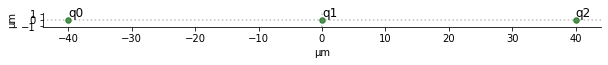

10.0%. Run time:   0.07s. Est. time left: 00:00:00:00
20.0%. Run time:   0.31s. Est. time left: 00:00:00:01
30.0%. Run time:   0.44s. Est. time left: 00:00:00:01
40.0%. Run time:   0.56s. Est. time left: 00:00:00:00
50.0%. Run time:   0.63s. Est. time left: 00:00:00:00
60.0%. Run time:   0.69s. Est. time left: 00:00:00:00
70.0%. Run time:   0.77s. Est. time left: 00:00:00:00
80.0%. Run time:   0.82s. Est. time left: 00:00:00:00
90.0%. Run time:   0.92s. Est. time left: 00:00:00:00
Total run time:   0.98s


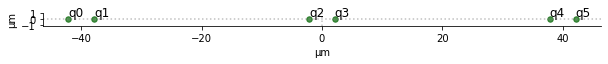

10.0%. Run time:   0.08s. Est. time left: 00:00:00:00
20.0%. Run time:   0.17s. Est. time left: 00:00:00:00
30.0%. Run time:   0.26s. Est. time left: 00:00:00:00
40.0%. Run time:   0.34s. Est. time left: 00:00:00:00
50.0%. Run time:   0.43s. Est. time left: 00:00:00:00
60.0%. Run time:   0.50s. Est. time left: 00:00:00:00
70.0%. Run time:   0.59s. Est. time left: 00:00:00:00
80.0%. Run time:   0.73s. Est. time left: 00:00:00:00
90.0%. Run time:   0.86s. Est. time left: 00:00:00:00
Total run time:   1.05s


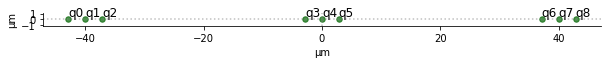

10.0%. Run time:   1.81s. Est. time left: 00:00:00:16
20.0%. Run time:   3.05s. Est. time left: 00:00:00:12
30.0%. Run time:   5.02s. Est. time left: 00:00:00:11
40.0%. Run time:   6.20s. Est. time left: 00:00:00:09
50.0%. Run time:   7.49s. Est. time left: 00:00:00:07
60.0%. Run time:   9.54s. Est. time left: 00:00:00:06
70.0%. Run time:  12.31s. Est. time left: 00:00:00:05
80.0%. Run time:  14.46s. Est. time left: 00:00:00:03
90.0%. Run time:  17.45s. Est. time left: 00:00:00:01
Total run time:  20.40s


In [4]:
data = [blockade_cluster(N) for N in [1,2,3]]  

We now plot the probability that a Rydberg state withing the cluster is occupied (by summing the expectation values of the $|r\rangle\langle r|_i$ operators for each cluster) as it evolves in time, revealing the Rabi frequency of each configuration:

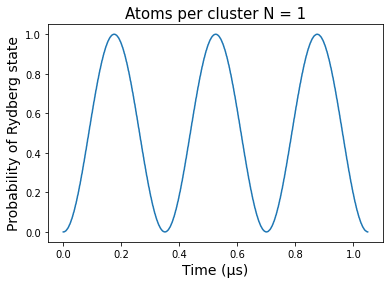

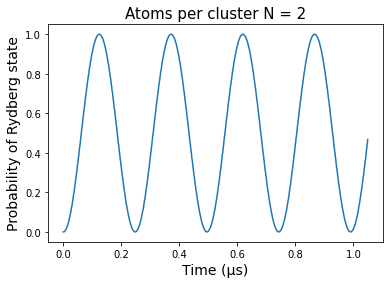

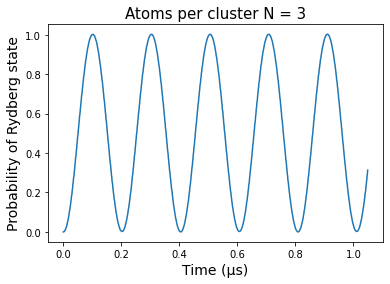

In [5]:
for N, expectation in enumerate(data):
    plt.xlabel('Time (µs)', fontsize=14)
    plt.ylabel('Probability of Rydberg state', fontsize=14)
    plt.title(f'Atoms per cluster N = {N+1}', fontsize = 15)
    avg = sum(expectation)/groups
    plt.plot(np.arange(len(avg))/1000, avg)
    plt.show()

Only one excitation will be shared between the atoms on each cluster. Notice how the Rabi frequency increases by a factor of $\sqrt{N}$ 

## 2. Ordered Crystalline phases

The pulse sequence that we will prepare is based on the following parameters:

In [6]:
# Parameters in rad/µs and ns
delta_0 = -6 * 2*np.pi
delta_f = 10 * 2*np.pi
Omega_max = 2 * 2*np.pi  
t_rise = 500
t_stop = 4500
t_end = 5000

We calculate the blockade radius from the maximal applied Rabi frequency:

Blockade Radius is: 8.57865851586716µm.


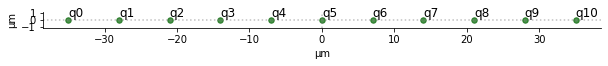

In [7]:
R_blockade = MockDevice.rydberg_blockade_radius(Omega_max)
a = 7.

reg = Register.rectangle(1,11, spacing=a, prefix='q')
print(f'Blockade Radius is: {R_blockade}µm.')
reg.draw()

Create the pulses using Pulser objects:

In [8]:
hold = ConstantWaveform(t_rise, delta_0)
excite = RampWaveform(t_stop - t_rise, delta_0, delta_f)
sweep = Pulse.ConstantAmplitude(Omega_max, CompositeWaveform(hold, excite), 0.)
stay = Pulse.ConstantPulse(t_end - t_stop, 0., delta_f, 0.)

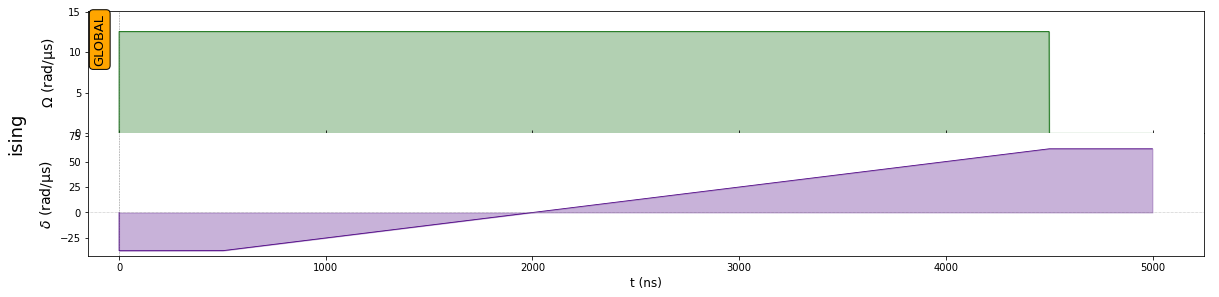

In [9]:
seq = Sequence(reg, MockDevice)
seq.declare_channel('ising', 'rydberg_global')

seq.add(sweep, 'ising')
seq.add(stay, 'ising')

#print(seq)
seq.draw()

The pulse sequence we just created corresponds a path in the Phase space of the ground state, which we represent schematically with the following function:

In [10]:
def phase_diagram(seq):
    ratio = []
    for x in seq._schedule['ising']:
        if isinstance(x.type,Pulse):
            ratio += list(x.type.detuning.samples/Omega_max)

    fig, ax = plt.subplots()
    ax.grid(True, which='both')

    ax.set_ylabel(r"Interaction Range $R_b/a$", fontsize=14)
    ax.set_xlabel(r"Detuning $\delta/\Omega$", fontsize=14)
    ax.set_xlim(-4,6)
    ax.set_ylim(0,3.2)
    ax.axhline(y=0, color='k')
    ax.axvline(x=0, color='k')

    y = np.arange(0.0, 5, 0.01)
    x = 2*(0.6+8*(y-1.2)**2)
    ax.fill_between(x, y, alpha=0.4)

    y = np.arange(0.0, 5, 0.01)
    x = 2*(0.8+50*(y-2.45)**2)
    ax.fill_between(x, y, alpha=0.4)

    y = np.arange(0.0, 5, 0.01)
    x = 2*(1.+170*(y-2.85)**2)
    ax.fill_between(x, y, alpha=0.4)


    ax.plot(np.array(ratio), np.full(len(ratio), R_blockade/a),'red',lw=2)
    plt.show()

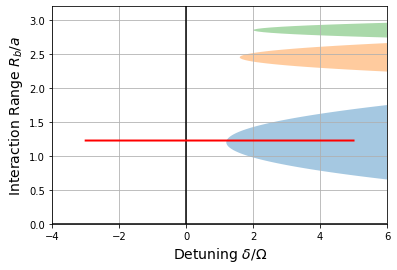

In [11]:
phase_diagram(seq)

### 2.1 Simulation

We run our simulation, for a list of observables corresponding to $|r\rangle \langle r|_j$ for each atom in the register:

In [12]:
simul = Simulation(seq, sampling_rate=.1)

occup_list = [occupation(reg, j) for j in range(len(reg.qubits))]

res = simul.run(progress_bar=True)
occupations = res.expect(occup_list)

10.0%. Run time:   1.18s. Est. time left: 00:00:00:10
20.0%. Run time:   2.38s. Est. time left: 00:00:00:09
30.0%. Run time:   4.58s. Est. time left: 00:00:00:10
40.0%. Run time:   6.17s. Est. time left: 00:00:00:09
50.0%. Run time:   7.47s. Est. time left: 00:00:00:07
60.0%. Run time:   8.73s. Est. time left: 00:00:00:05
70.0%. Run time:   9.83s. Est. time left: 00:00:00:04
80.0%. Run time:  11.35s. Est. time left: 00:00:00:02
90.0%. Run time:  13.25s. Est. time left: 00:00:00:01
Total run time:  14.88s


The following function plots the evolution of the expectation values with respect to time:

In [13]:
def plot_evolution(results):
    plt.figure(figsize=(10,5))
    plt.xlabel('Time (µs)', fontsize=14)
    plt.ylabel('Rydberg Occupation Probabilty', fontsize=14)
    for expv in results:
        plt.plot(np.arange(len(expv))/1000,expv)

    plt.show()

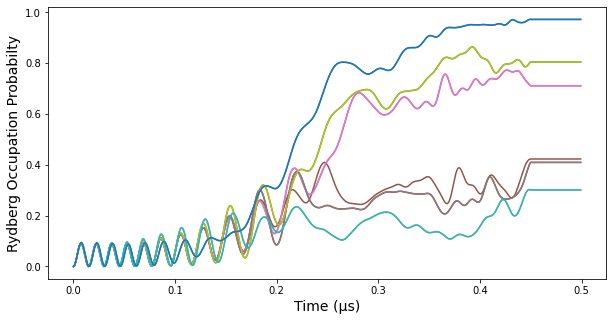

In [14]:
plot_evolution(occupations)

We finally plot the probability of occupation of the Rydberg level with respect to the values of detuning, for each atom in the array:

In [15]:
def heat_detuning(data,start,end):
    N = len(reg.qubits)
    time_window = []
    x =[]
    detunings = simul.samples['Global']['ground-rydberg']['det'][[int(1000*t) for t in simul._times]]

    for t,d in enumerate(detunings):
        if start <= d <= end:
            time_window.append(t)
            x.append(d/(2*np.pi))

    y = np.arange(1,N+1)

    X, Y = np.meshgrid(x, y)
    Z = np.array(data)[:,time_window]

    plt.figure(figsize=(14,3))
    plt.pcolormesh(X,Y,Z, cmap='hot', shading='auto')
    plt.xlabel('Detuning/2π (MHz)', fontsize=14)
    plt.ylabel('Atom in array', fontsize=14)
    plt.yticks(range(1,N+1), [f'q{i}' for i in range(N)], va='center')
    plt.colorbar(fraction=0.047, pad=0.015)
    
    plt.show()

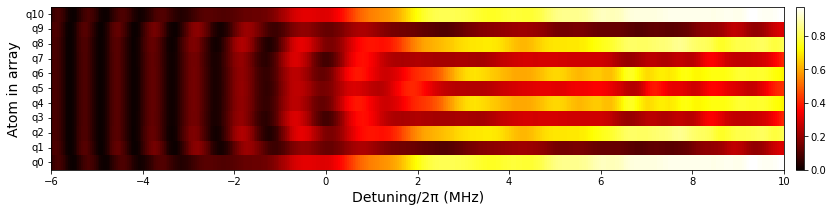

In [16]:
heat_detuning(occupations, delta_0, delta_f)

### 2.2 Rydberg Crystals: $Z_3$ Order

To arrive at a different phase, we reduce the interatomic distance $a$, thus increasing the interaction range between the atoms. This will lead to a $Z_3$ ordered phase: 

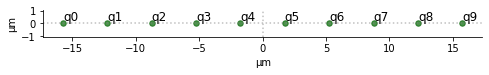

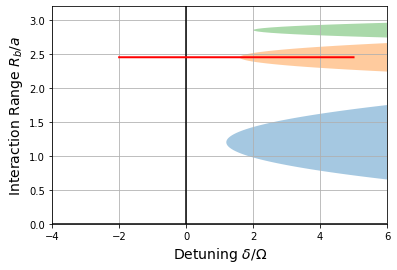

10.0%. Run time:   3.65s. Est. time left: 00:00:00:32
20.0%. Run time:   7.43s. Est. time left: 00:00:00:29
30.0%. Run time:   9.90s. Est. time left: 00:00:00:23
40.0%. Run time:  11.89s. Est. time left: 00:00:00:17
50.0%. Run time:  13.47s. Est. time left: 00:00:00:13
60.0%. Run time:  15.10s. Est. time left: 00:00:00:10
70.0%. Run time:  16.60s. Est. time left: 00:00:00:07
80.0%. Run time:  18.08s. Est. time left: 00:00:00:04
90.0%. Run time:  19.60s. Est. time left: 00:00:00:02
Total run time:  20.65s


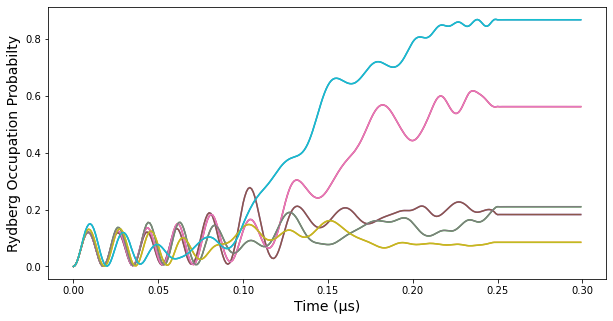

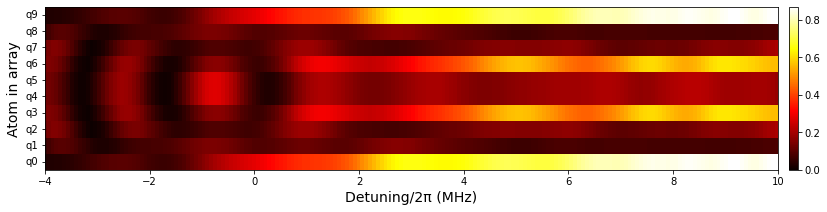

In [17]:
a = 3.5
reg = Register.rectangle(1, 10, spacing=a, prefix='q')
reg.draw()

delta_0 = -4 * 2*np.pi
delta_f = 10 * 2*np.pi
Omega_max = 2.0 * 2*np.pi  # btw 1.8-2 * 2pi MHz
t_rise = 600
t_stop = 2500
t_end = 3000

#
hold = ConstantWaveform(t_rise, delta_0)
excite = RampWaveform(t_stop - t_rise, delta_0, delta_f)
sweep = Pulse.ConstantAmplitude(Omega_max, CompositeWaveform(hold, excite), 0.)
stay = Pulse.ConstantPulse(t_end - t_stop, 0., delta_f, 0.)

#
seq = Sequence(reg, MockDevice)
seq.declare_channel('ising', 'rydberg_global')

seq.add(sweep, 'ising')
seq.add(stay, 'ising')

#print(seq)
#seq.draw()
phase_diagram(seq)

simul = Simulation(seq, sampling_rate=0.1)

occup_list = [occupation(reg, j) for j in range(simul._size)]

res = simul.run(progress_bar=True, method='bdf')

occupations = res.expect(occup_list)

plot_evolution(occupations)
heat_detuning(occupations, delta_0, delta_f)

### 2.3 Rydberg Crystals: $Z_4$ Order

Decreasing even more the interatomic distance leads to a $Z_4$ order. The magnitude of the Rydberg interaction with respect to that of the applied pulses means our solver has to control terms with a wider range, thus leading to longer simulation times:

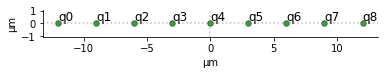

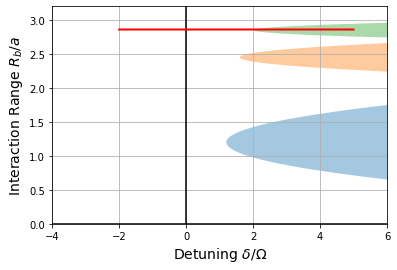

10.0%. Run time:   1.71s. Est. time left: 00:00:00:15
20.0%. Run time:   3.12s. Est. time left: 00:00:00:12
30.0%. Run time:   4.99s. Est. time left: 00:00:00:11
40.0%. Run time:   6.63s. Est. time left: 00:00:00:09
50.0%. Run time:   8.18s. Est. time left: 00:00:00:08
60.0%. Run time:   9.71s. Est. time left: 00:00:00:06
70.0%. Run time:  11.01s. Est. time left: 00:00:00:04
80.0%. Run time:  12.69s. Est. time left: 00:00:00:03
90.0%. Run time:  13.98s. Est. time left: 00:00:00:01
Total run time:  15.40s


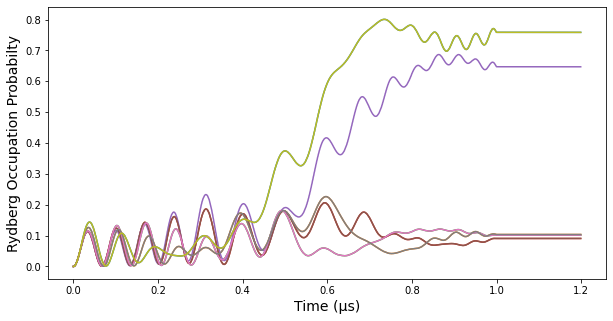

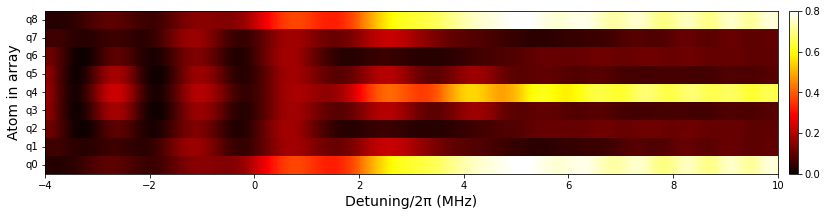

In [18]:
a = 3
reg = Register.rectangle(1,9, spacing=a, prefix='q')
reg.draw()

# Parameters in rad/µs and ns

delta_0 = -4 * 2*np.pi
delta_f = 10 * 2*np.pi
Omega_max = 2.0 * 2*np.pi  # btw 1.8-2 2pi*MHz
t_rise = 600
t_stop = 2500
t_end = 3000

#
hold = ConstantWaveform(t_rise, delta_0)
excite = RampWaveform(t_stop - t_rise, delta_0, delta_f)
sweep = Pulse.ConstantAmplitude(Omega_max, CompositeWaveform(hold, excite), 0.)
stay = Pulse.ConstantPulse(t_end - t_stop, 0., delta_f, 0.)

#
seq = Sequence(reg, MockDevice)
seq.declare_channel('ising', 'rydberg_global')

seq.add(sweep, 'ising')
seq.add(stay, 'ising')

#print(seq)
#seq.draw()
phase_diagram(seq)

simul = Simulation(seq, sampling_rate=0.4)
    
occup_list = [occupation(reg, j) for j in range(simul._size)]

#
res = simul.run(progress_bar=True, method='bdf')
occupations = res.expect(occup_list)

plot_evolution(occupations)        
heat_detuning(occupations,delta_0,delta_f)
